<a href="https://colab.research.google.com/github/IsabelaAyres/datascience/blob/main/MVP_Machine_Learning_and_Analytics/MVP_Deep_Learning_Isabela_Ayres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics

>**PUC-Rio**
>
>**Postgraduate Course in Data Science and Analytics**
>
>**Student: Isabela Ayres**


# DEEP LEARNING


---

Using Neural Networks for Object Detection in Images: Application in the Field of Workplace Safety

## 1. Problem Definition


### 1.1 Context

The field of Deep Learning has revolutionized how machines process and interpret visual information. With the ability to extract complex features and recognize patterns in images, Deep Learning stands out as a powerful technique for object identification in different contexts.

In this project, we will explore its application in identifying individuals without Personal Protective Equipment (PPE), with a specific focus on detecting Safety Helmets.

Safety Helmets are of utmost importance, designed to protect the head against impacts, falling objects, and other hazards present in the workplace environment. Ensuring that individuals are correctly wearing this equipment is essential to prevent severe accidents and preserve the physical integrity of workers.

The aim of this study is to employ object identification techniques in images, based on Deep Learning, to automatically detect individuals without Safety Helmets in an industrial environment.

With automated detection, immediate actions such as sending alerts to the safety team or activating audible warning devices can be taken to prevent accidents and ensure people's safety.

## 2. Setup

### 2.1 Imports

Starting with the importation of the libraries to be used.

In [1]:
# Configuration to suppress warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Execute inference in the TF-Hub module
import tensorflow as tf
import tensorflow_hub as hub

# Download the images
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# Draw on the images
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Measure inference time
import time

# TensorFlow version
print(tf.__version__)

2.12.0


### 2.2 Function Creation

Next, we will create the functions responsible for processing the image and drawing bounding boxes.

In [2]:
# Display the image
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

# Download and resize the image
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


# Add a bounding box to the image
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)


  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]


  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height


  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


# Overlay labeled bounding boxes on an image with formatted scores and class names
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.30):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## 3. Modeling and Training


We can use two different neural networks for object detection:

*   **FasterRCNN+InceptionResNet V2**: Better accuracy
*   **ssd+mobilenet V2**: Small and fast for inference

We will use TensorFlow Hub to download pretrained models.


In [3]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

To identify individuals without helmets, we will use two example images: one where all individuals are wearing helmets and another where at least one person is without a helmet.

Image downloaded to /tmp/tmpzfu90x1a.jpg.


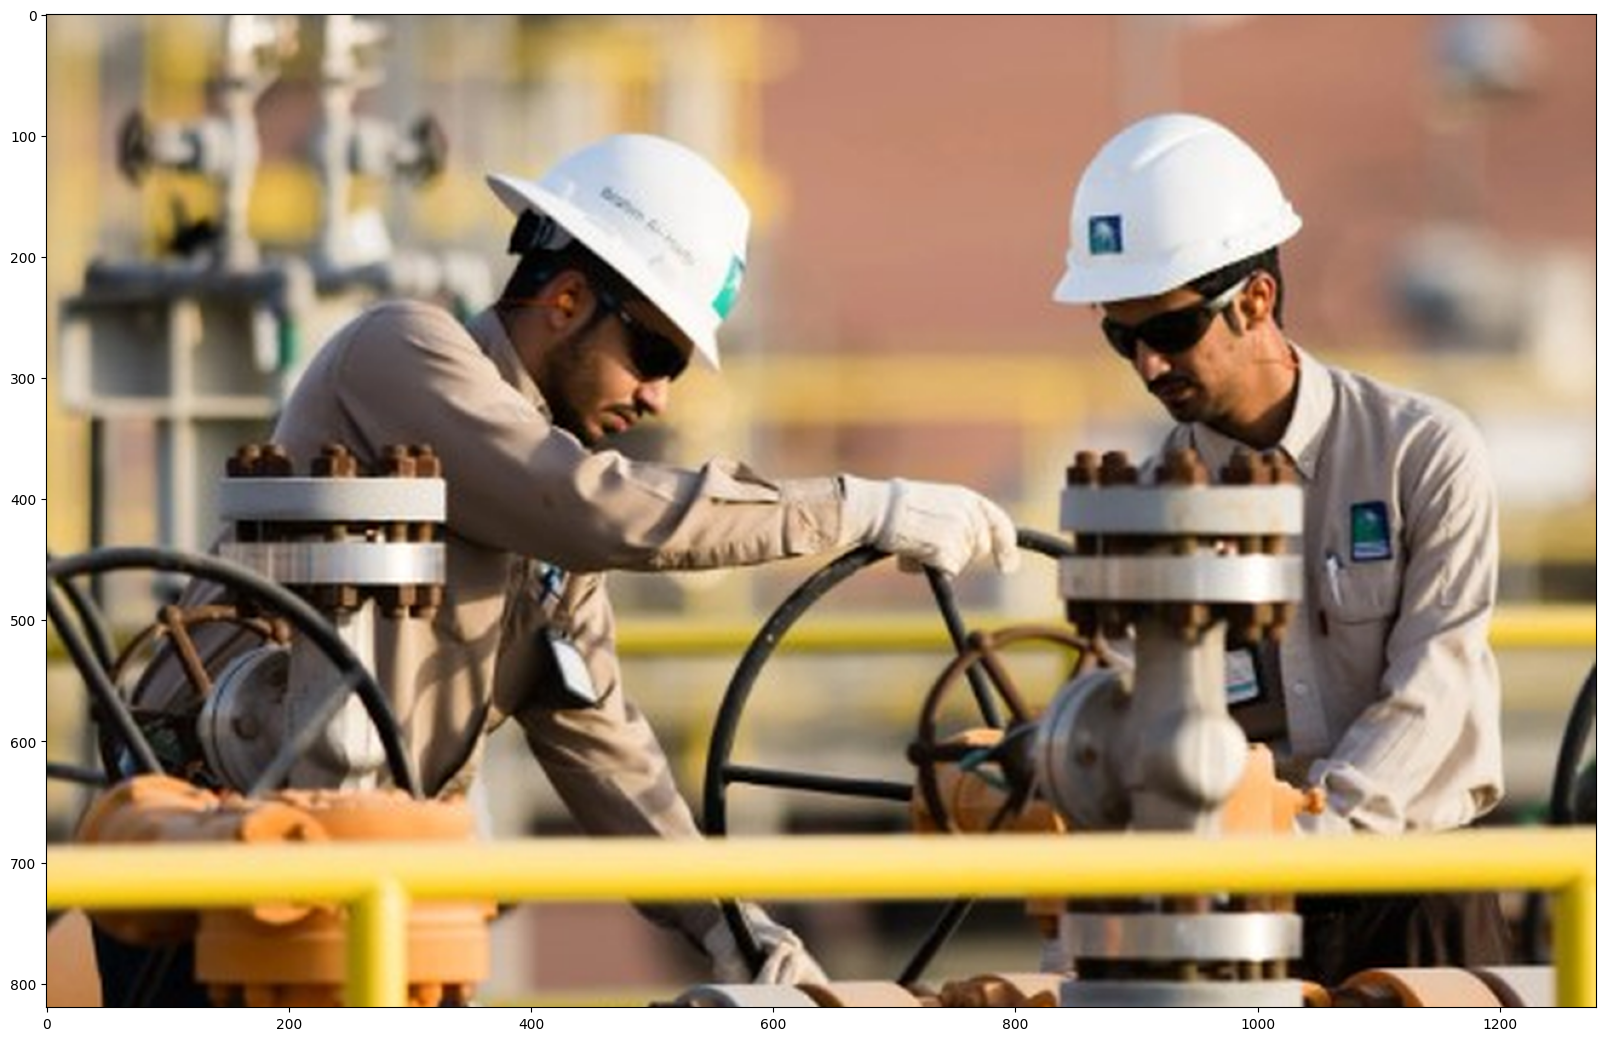

In [4]:
# Loading the image (web image URL: https://epbr.com.br/preco-do-petroleo-ainda-resiste-a-pressao-da-opep/)
image_url = "https://raw.githubusercontent.com/IsabelaAyres/datascience/main/MVP_Machine_Learning_and_Analytics/picture1.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 820, True)

In [6]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  # Loading image
  img = load_img(path)

  # Detecting objects
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key:value.numpy() for key,value in result.items()}

  # Drawing boxes on the image
  image_with_boxes = draw_boxes(
     img.numpy(), result["detection_boxes"],
     result["detection_class_entities"], result["detection_scores"])

  # Displaying the image with identified objects
  display_image(image_with_boxes)

  # Saving a list of identified objects and converting it into a table
  result_object = result['detection_class_entities']
  result_score = result['detection_scores']
  result_table = pd.DataFrame(
      {'list_object': result_object,
       'list_score': result_score})

  # Correcting the data format
  result_table.list_object = result_table.list_object.astype(str)

  # Cleaning characters
  result_table['list_object'] = result_table['list_object'].str.replace("b'", '').str.replace("'", '')

  # Selecting the score range
  result_table = result_table[result_table['list_score'] > 0.30]

  # Counting People and Helmet objects
  result_table = result_table.drop('list_score',axis=1)
  result_table_person = result_table[result_table['list_object'] == 'Person'].value_counts().values
  result_table_helmet = result_table[result_table['list_object'] == 'Helmet'].value_counts().values

  # Alert message
  if result_table_person == result_table_helmet:
    result_table = pd.DataFrame(
    {'Message': "OK",
    'Total Person': result_table_person,
    'Total Helmet': result_table_helmet})

    display(result_table.style.set_properties(**{'background-color': 'green', 'color': 'white'}).set_caption('ANALYSIS'))

  else:
    result_table = pd.DataFrame(
    {'Message': "Attention! Missing Helmet",
    'Total Person': result_table_person,
    'Total Helmet': result_table_helmet})

    display(result_table.style.set_properties(**{'background-color': 'red', 'color': 'white'}).set_caption('ANALYSIS'))

run_detector(detector, downloaded_image_path)

Now let's move on to an example with individuals without helmet.

Image downloaded to /tmp/tmpjnlwwqy9.jpg.


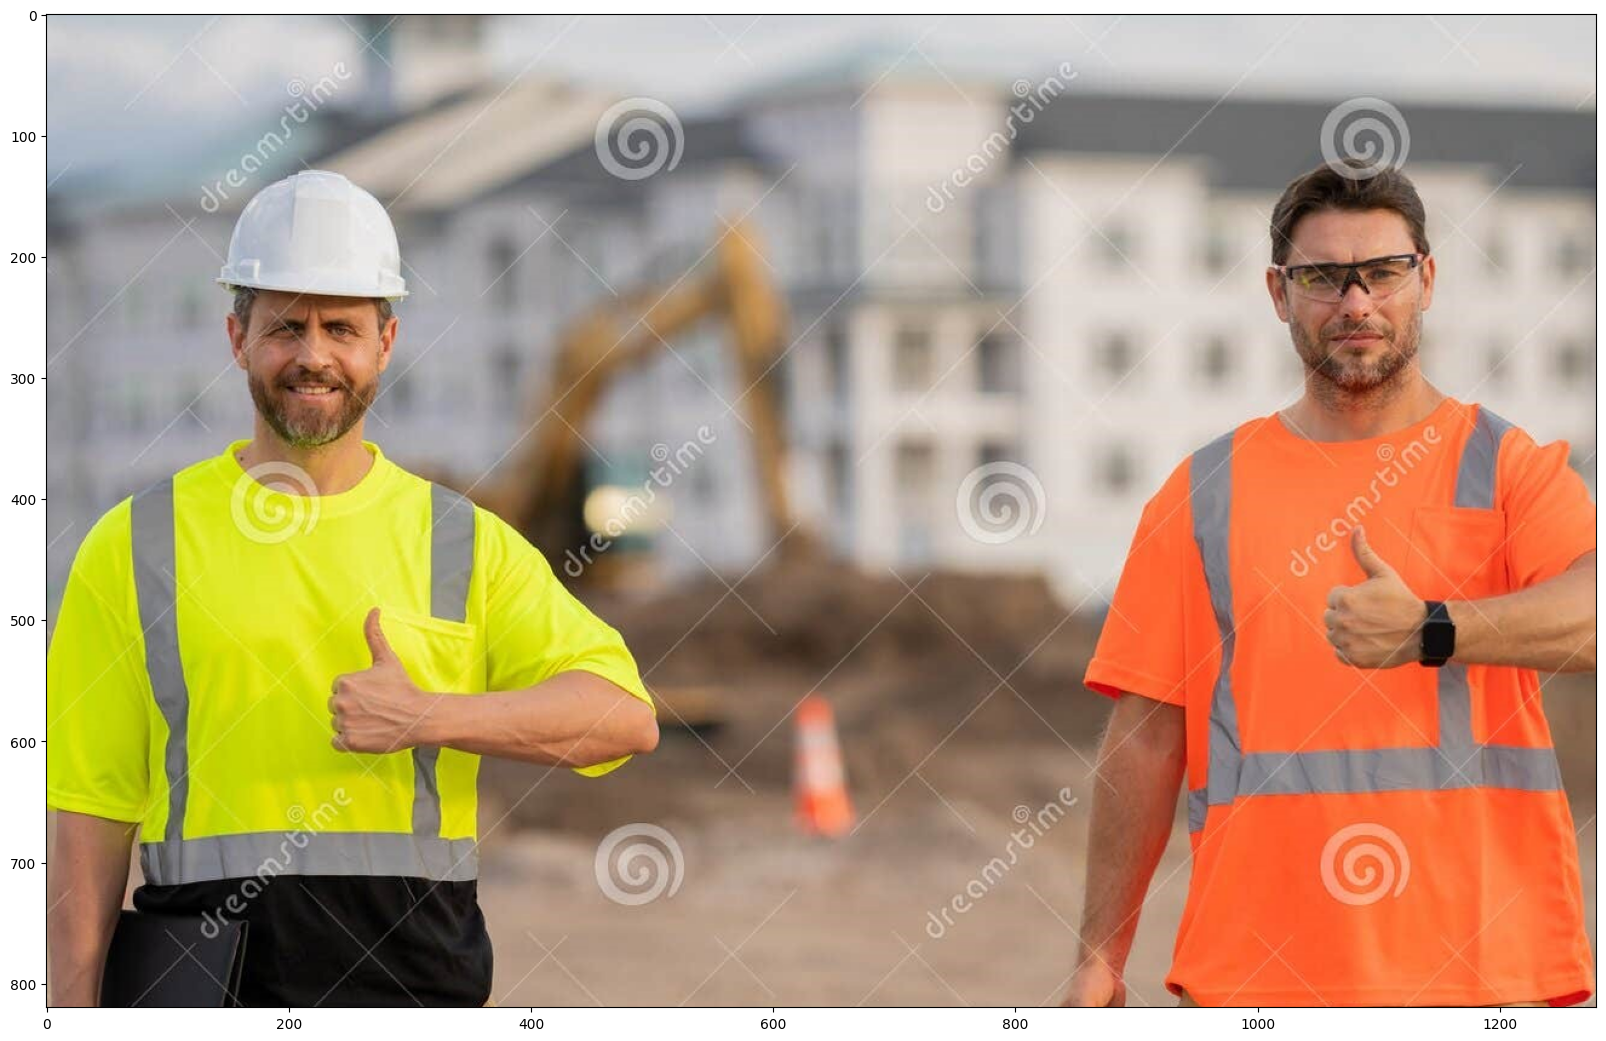

In [7]:
# Loading the image (web image URL: https://pt.dreamstime.com/trabalhadores-de-canteiros-obras-capacete-dois-um-chap%C3%A9u-r%C3%ADgido-%C3%A9-respons%C3%A1vel-por-garantir-seguran%C3%A7a-enquanto-durante-image278472385)
image_url = "https://raw.githubusercontent.com/IsabelaAyres/datascience/main/MVP_Machine_Learning_and_Analytics/picture2.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 820, True)

In [8]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  # Loading image
  img = load_img(path)

  # Detecting objects
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key:value.numpy() for key,value in result.items()}

  # Drawing boxes on the image
  image_with_boxes = draw_boxes(
     img.numpy(), result["detection_boxes"],
     result["detection_class_entities"], result["detection_scores"])

  # Displaying the image with identified objects
  display_image(image_with_boxes)

  # Saving a list of identified objects and converting it into a table
  result_object = result['detection_class_entities']
  result_score = result['detection_scores']
  result_table = pd.DataFrame(
      {'list_object': result_object,
       'list_score': result_score})

  # Correcting the data format
  result_table.list_object = result_table.list_object.astype(str)

  # Cleaning characters
  result_table['list_object'] = result_table['list_object'].str.replace("b'", '').str.replace("'", '')

  # Selecting the score range
  result_table = result_table[result_table['list_score'] > 0.10]

  # Counting People and Helmet objects
  result_table = result_table.drop('list_score',axis=1)
  result_table_person = result_table[result_table['list_object'] == 'Person'].value_counts().values
  result_table_helmet = result_table[result_table['list_object'] == 'Helmet'].value_counts().values

  # Alert message
  if result_table_person == result_table_helmet:
    result_table = pd.DataFrame(
    {'Message': "OK",
    'Total Person': result_table_person,
    'Total Helmet': result_table_helmet})

    display(result_table.style.set_properties(**{'background-color': 'green', 'color': 'white'}).set_caption('ANALYSIS'))

  else:
    result_table = pd.DataFrame(
    {'Message': "Attention! Missing Helmet",
    'Total Person': result_table_person,
    'Total Helmet': result_table_helmet})

    display(result_table.style.set_properties(**{'background-color': 'red', 'color': 'white'}).set_caption('ANALYSIS'))

run_detector(detector, downloaded_image_path)

## 4. Results Evaluation


In this study, object detection in images was used to identify individuals without safety helmets in a workplace environment. The results obtained were satisfactory, allowing for efficient identification of individuals without helmets.

However, it is important to highlight that there are opportunities for improvement. During testing, it was observed that the model exhibits higher accuracy in detecting white helmets. Additionally, the angle of the helmet in the image affects the detection accuracy score, which opens room for enhancements in model training considering different colors, angles, and positions of the helmet.

Furthermore, an interesting suggestion to further enhance the solution's utility would be to integrate the model with an audible alert system. This way, in addition to visual detection, an audible alert could be triggered, providing an additional layer of safety and accident prevention.

In summary, despite the areas for improvement, the results obtained in this study demonstrated efficient detection of individuals without helmets in a workplace environment. This could serve as a starting point for implementations in the field of Workplace Safety in industries.